## Assignment

In this assignment, you'll continue working with the Students Performance in Exams dataset from Kaggle. You should access the data from the Thinkful database. Here's the credentials you can use to connect to the database:

postgres_user = 'dsbc_student'<br>
postgres_pw = '7\*.8G9QH21'<br>
postgres_host = '142.93.121.174'<br>
postgres_port = '5432'<br>
postgres_db = 'studentsperformance'<br>

To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?
2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.
3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

Submit your work below, and plan on discussing with your mentor. You can also take a look at these [example solutions](https://github.com/Thinkful-Ed/data-201-assignment-solutions/blob/master/model_prep_feature_engineering_1/solution.ipynb).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from scipy.stats import normaltest
from sklearn.preprocessing import normalize
from scipy.stats import boxcox

In [2]:
user = 'dsbc_student'
pw = '7*.8G9QH21'
host = '142.93.121.174'
port = '5432'
db = 'studentsperformance'

In [3]:
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{db}')
engine.table_names()

['studentsperformance']

In [4]:
sql_query ='''
SELECT 
    *
FROM
    studentsperformance
''' 
stpf_df = pd.read_sql(sql_query,con=engine)
engine.dispose()

In [5]:
stpf_df.columns = stpf_df.columns.to_series().replace(' ', '_', regex=True)
stpf_df.columns = stpf_df.columns.to_series().replace('/', '_', regex=True)
stpf_df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


1. Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

In [6]:
math_score_normal_p = normaltest(stpf_df["math_score"])[1]
reading_score_normal_p = normaltest(stpf_df["reading_score"])[1]
writing_score_normal_p = normaltest(stpf_df["writing_score"])[1]
print("math p value is {}, reading is {}, and writing is {}".format(math_score_normal_p, writing_score_normal_p, reading_score_normal_p))

math p value is 0.00045080293869937836, reading is 0.0011101885439899974, and writing is 0.003853758403576582


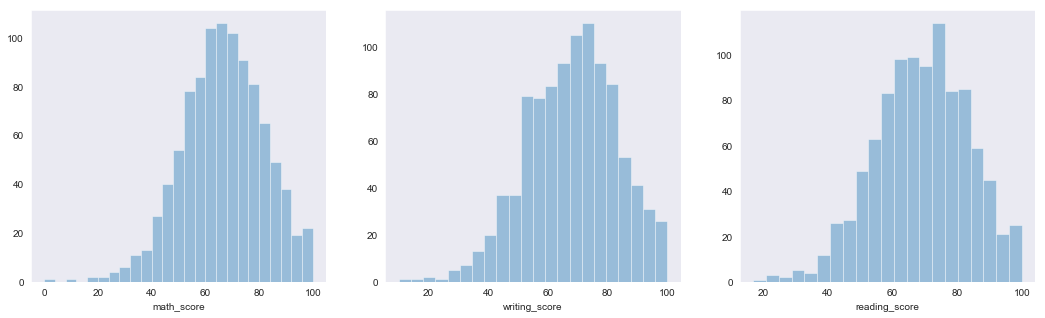

In [7]:
sns.set_style("dark")
plt.figure(figsize=(18,5))    
plt.subplot(1,3,1)
sns.distplot(stpf_df["math_score"], kde=False)
plt.subplot(1,3,2)
sns.distplot(stpf_df["writing_score"], kde=False)
plt.subplot(1,3,3)
sns.distplot(stpf_df["reading_score"], kde=False)
plt.show()

all distributions appear normally distributed, perhaps some left skew.

In [29]:
#make all entries > 0 so they are valid input for box-cox transform fnc
math_min = abs(stpf_df.math_score.min()) + 1
reading_min = abs(stpf_df.reading_score.min()) + 1
writing_min = abs(stpf_df.writing_score.min()) + 1
math_min

1

In [30]:
#create boxcox normalized version of test scores
stpf_df["math_boxcox"] = boxcox(stpf_df["math_score"] + math_min)[0]
stpf_df["read_boxcox"] = boxcox(stpf_df["reading_score"] + reading_min)[0]
stpf_df["write_boxcox"] = boxcox(stpf_df["writing_score"] + writing_min)[0]

In [10]:
mathbc_score_normal_p = normaltest(stpf_df["math_boxcox"])[1]
readingbc_score_normal_p = normaltest(stpf_df["read_boxcox"])[1]
writingbc_score_normal_p = normaltest(stpf_df["write_boxcox"])[1]
print("math p value is {}, reading is {}, and writing is {}".format(mathbc_score_normal_p, writingbc_score_normal_p, readingbc_score_normal_p))

math p value is 0.6550583088884472, reading is 0.05488252979847783, and writing is 0.0883900490088434


value are somewhat better, but still not clearly normal

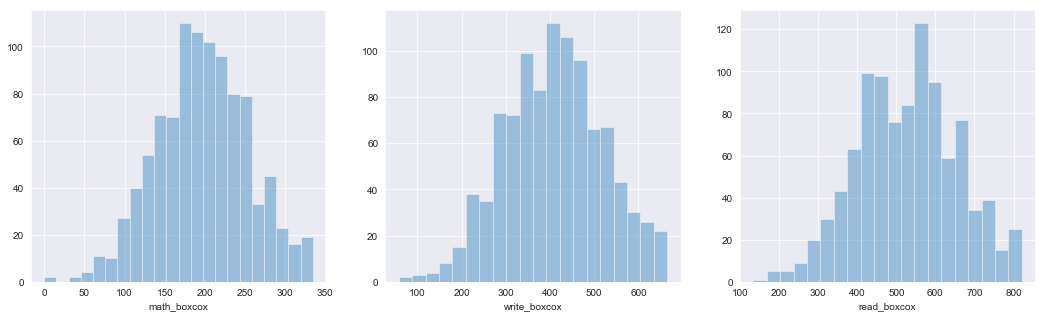

In [11]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,5))    
plt.subplot(1,3,1)
sns.distplot(stpf_df["math_boxcox"], kde=False)
plt.subplot(1,3,2)
sns.distplot(stpf_df["write_boxcox"], kde=False)
plt.subplot(1,3,3)
sns.distplot(stpf_df["read_boxcox"], kde=False)
plt.show()

2. Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

In [12]:
stpf_df["score_av"] = (stpf_df["reading_score"] + stpf_df["writing_score"] + stpf_df["math_score"])/3
stpf_df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,math_boxcox,read_boxcox,write_boxcox,score_av
0,female,group B,bachelor's degree,standard,none,72,72,74,217.560363,548.127889,450.223069,72.666667
1,female,group C,some college,standard,completed,69,90,88,205.795539,719.491195,562.724372,82.333333
2,female,group B,master's degree,standard,none,90,95,93,291.282655,769.744477,604.774155,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,124.768101,417.540655,238.037784,49.333333
4,male,group C,some college,standard,none,76,78,75,233.488415,603.540703,457.993876,76.333333


In [13]:
normaltest(stpf_df.score_av)[1]

0.0005037851534494478

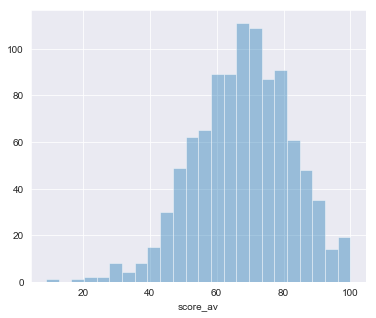

In [14]:
plt.figure(figsize=(6,5))
sns.distplot(stpf_df["score_av"], kde=False)
plt.show()

not at all normal...  
BoxCox version:

In [15]:
stpf_df["score_av_bc"] = boxcox(stpf_df.score_av)[0]
normaltest(stpf_df.score_av_bc)

NormaltestResult(statistic=2.779857245981238, pvalue=0.2490930835165177)

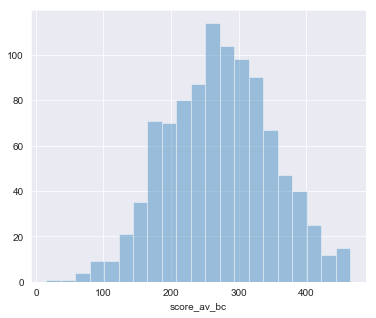

In [16]:
plt.figure(figsize=(6,5))
sns.distplot(stpf_df["score_av_bc"], kde=False)
plt.show()

3. Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

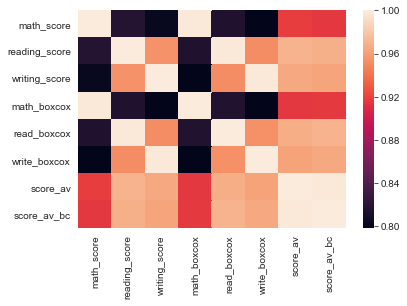

In [17]:
stpf_corr_df = stpf_df.corr()
sns.heatmap(stpf_corr_df)

In [18]:
stpf_df["female"] = (stpf_df.gender == "female").astype(int)

In [19]:
stpf_df = pd.concat([stpf_df, pd.get_dummies(stpf_df.race_ethnicity)], axis=1)

In [20]:
stpf_df = pd.concat([stpf_df, pd.get_dummies(stpf_df.parental_level_of_education)], axis=1)
stpf_df = pd.concat([stpf_df, pd.get_dummies(stpf_df.lunch)], axis=1)
stpf_df = pd.concat([stpf_df, pd.get_dummies(stpf_df.test_preparation_course)], axis=1)

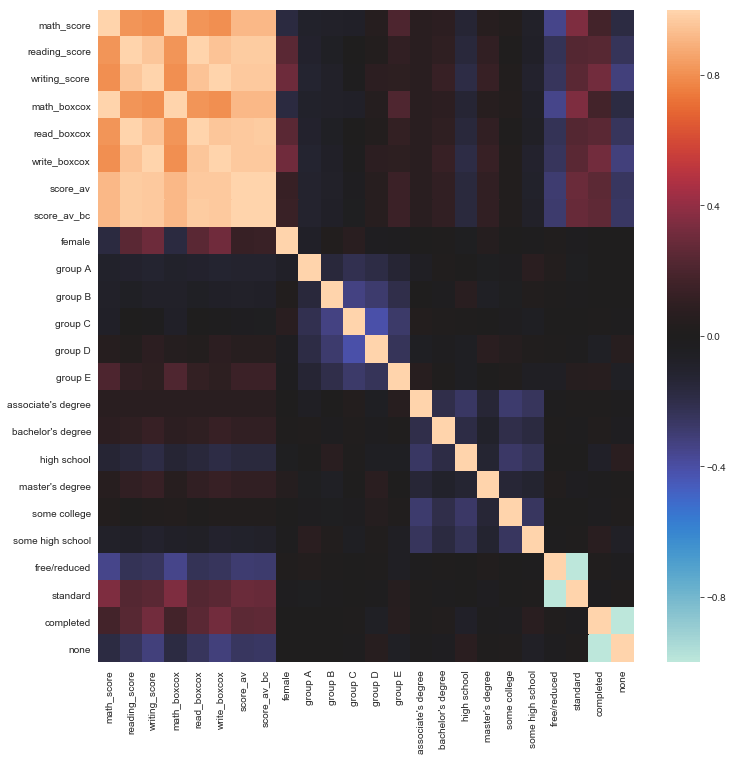

In [21]:
plt.figure(figsize=(12,12))
stpf_corr2_df = stpf_df.corr()
sns.heatmap(stpf_corr2_df, center=0)

In [22]:
stpf_corr2_df.score_av_bc.abs().sort_values(ascending=False)

score_av_bc           1.000000
score_av              0.997693
read_boxcox           0.970347
reading_score         0.968836
write_boxcox          0.964645
writing_score         0.963205
math_boxcox           0.917258
math_score            0.916145
standard              0.287215
free/reduced          0.287215
completed             0.258083
none                  0.258083
high school           0.163794
group E               0.145594
female                0.135389
bachelor's degree     0.108196
group A               0.104545
master's degree       0.104196
some high school      0.084954
group B               0.076994
associate's degree    0.066312
group D               0.056013
group C               0.032560
some college          0.025282
Name: score_av_bc, dtype: float64

The most correlated value are the score variables. The most useful would be standard or free/reduced lunch, and test prep completed or none.